In [1]:
import pickle
from typing import Optional
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from gurobipy import GRB
from plots import *
from ems_data import *
from simulation import *
from neural_network import *
from mip_models import *

TRAINING_METRICS = ['coverage_9min', 'coverage_15min', 'survival_rate', 'response_time_mean', 'response_time_median', 'response_time_90th_percentile']
FACILITY_CAPACITY = 4
TIME_LIMIT = 600
SUCCESS_PROB = 0.8

def plot_metric(X: np.ndarray, y: np.ndarray, metric: str, metric_short: Optional[str] = None):
    """Plot histogram and box plots side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle(metric)
    if metric_short is not None:
        metric = metric_short
    ax[0].hist(y, bins=100)
    ax[0].set_xlabel(metric)
    ax[0].set_ylabel("Frequency")
    plot_metric_by_ambulance_count(X, y, metric, ax=ax[1])
    return fig, ax

def best_solution_from_dataset(dataset: pd.DataFrame, n_ambulances: int, metric: str) -> tuple[pd.Series, pd.Series]:
    """Finds the best solution w.r.t. a metric for a given maximum number of ambulances."""
    X = dataset.drop(columns=METRICS)
    Y = dataset[METRICS]
    indices = np.where(X.sum(axis=1) <= n_ambulances)[0]
    argmin_or_argmax = np.argmin if 'response_time' in metric else np.argmax
    y = Y[metric]
    best_idx = indices[argmin_or_argmax(y[indices])]
    return X.iloc[best_idx], Y.iloc[best_idx]

def remove_outliers_at_each_ambulance_count(X, y, k=1.5):
    """For each total number of ambulances, isolate samples with that total and remove outliers.

    Parameters
    ----------
    X, y : np.ndarray
        The dataset.
    
    k : float
        y values outside the range [Q1 - k*IQR, Q3 + k*IQR] are considered outliers.
    
    Returns
    -------
    X_new, y_new : np.ndarray
        The dataset with outliers removed.
    """
    X_sum = X.sum(axis=1)
    min_ambulances = X_sum.min()
    max_ambulances = X_sum.max()
    keep = np.full(X.shape[0], False)
    for total in range(min_ambulances, max_ambulances+1):
        y_subset = y[X_sum == total]
        q1 = np.percentile(y_subset, 25)
        q3 = np.percentile(y_subset, 75)
        iqr = q3 - q1
        keep |= (
            (X_sum == total)
            & (y >= q1 - k*iqr)
            & (y <= q3 + k*iqr)
        )
    return X[keep], y[keep]

def rescale(x: np.ndarray, min: float = 0, max: float = 1) -> np.ndarray:
    """Shift and scale data to the range [min, max]."""
    return (x - x.min()) / (x.max() - x.min()) * (max - min) + min

print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

NVIDIA GeForce GTX 1070


device(type='cuda')

# stations: 46
# demand nodes: 2977


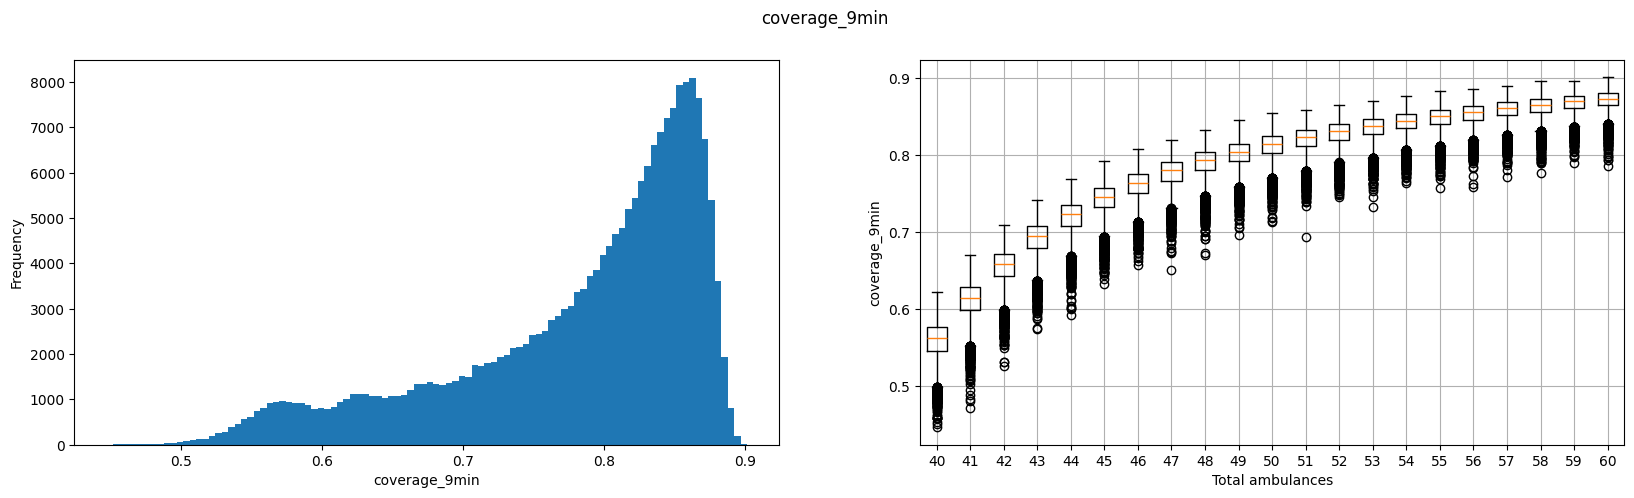

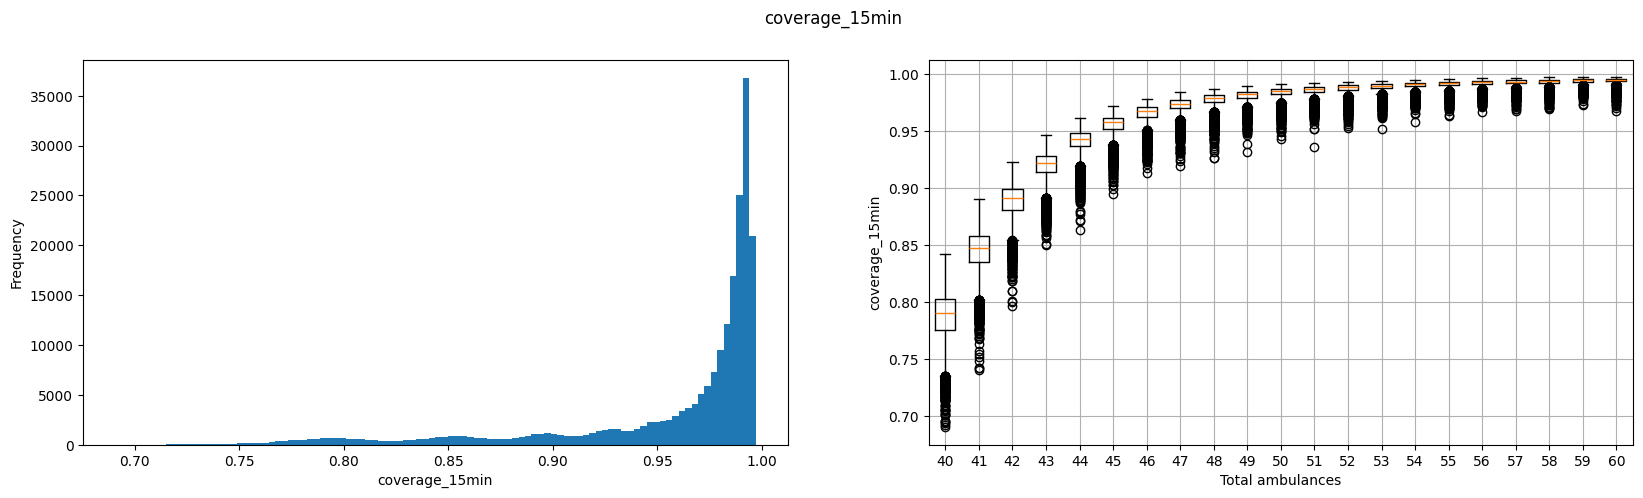

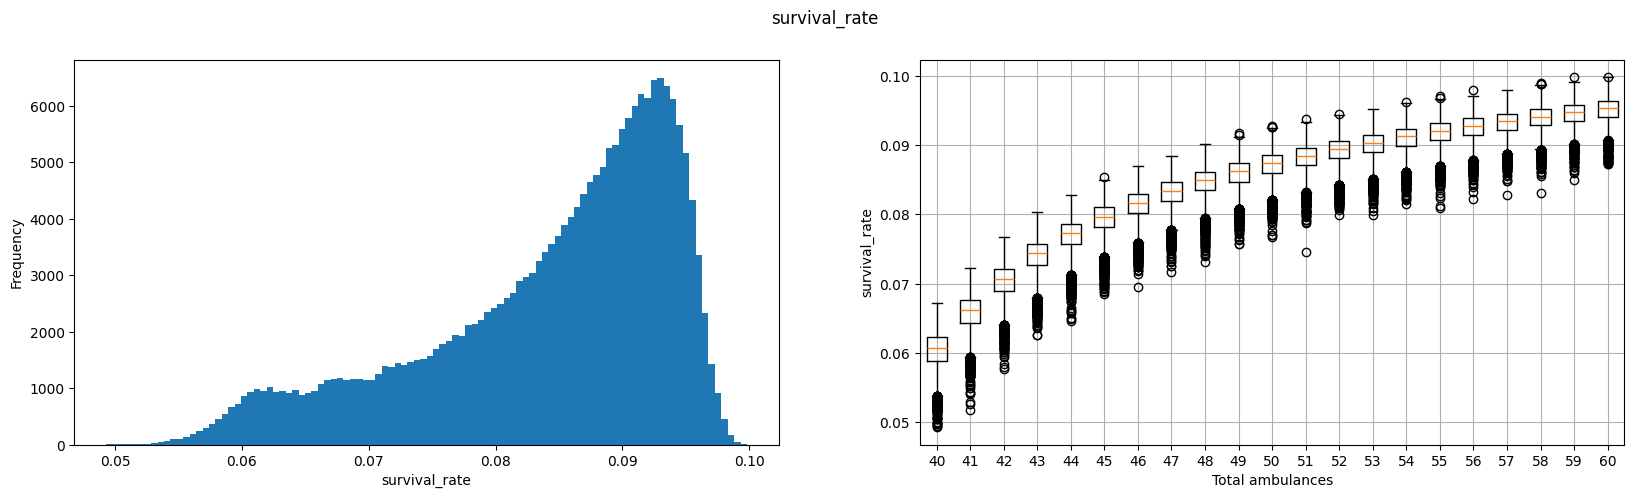

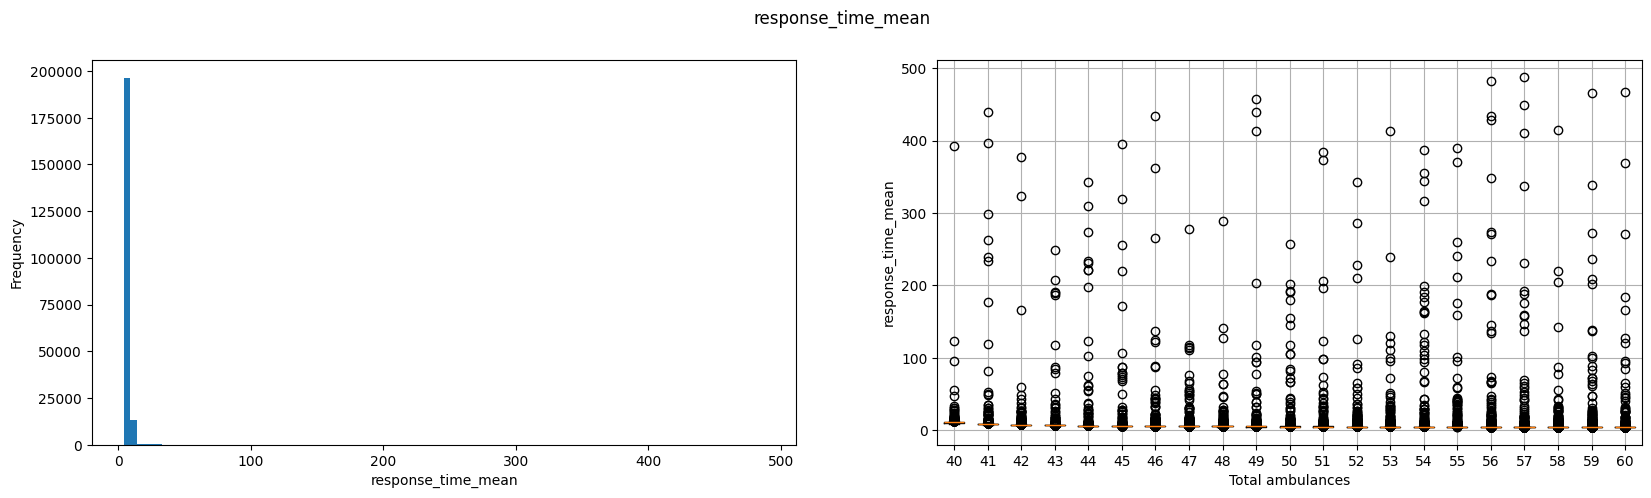

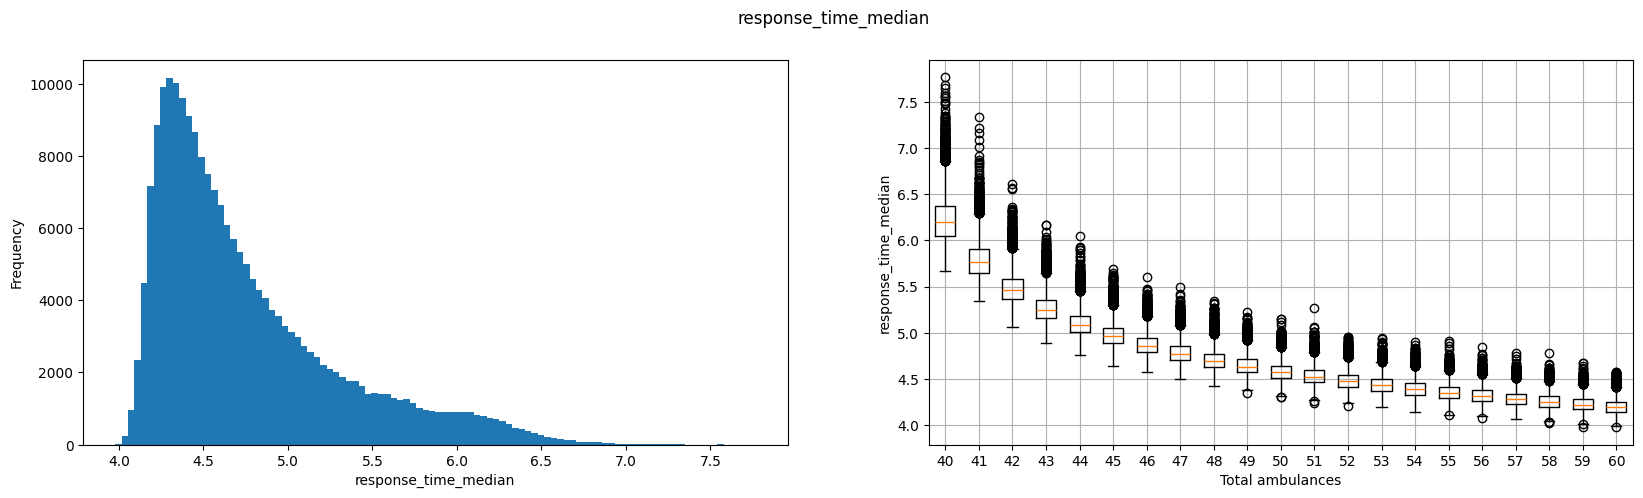

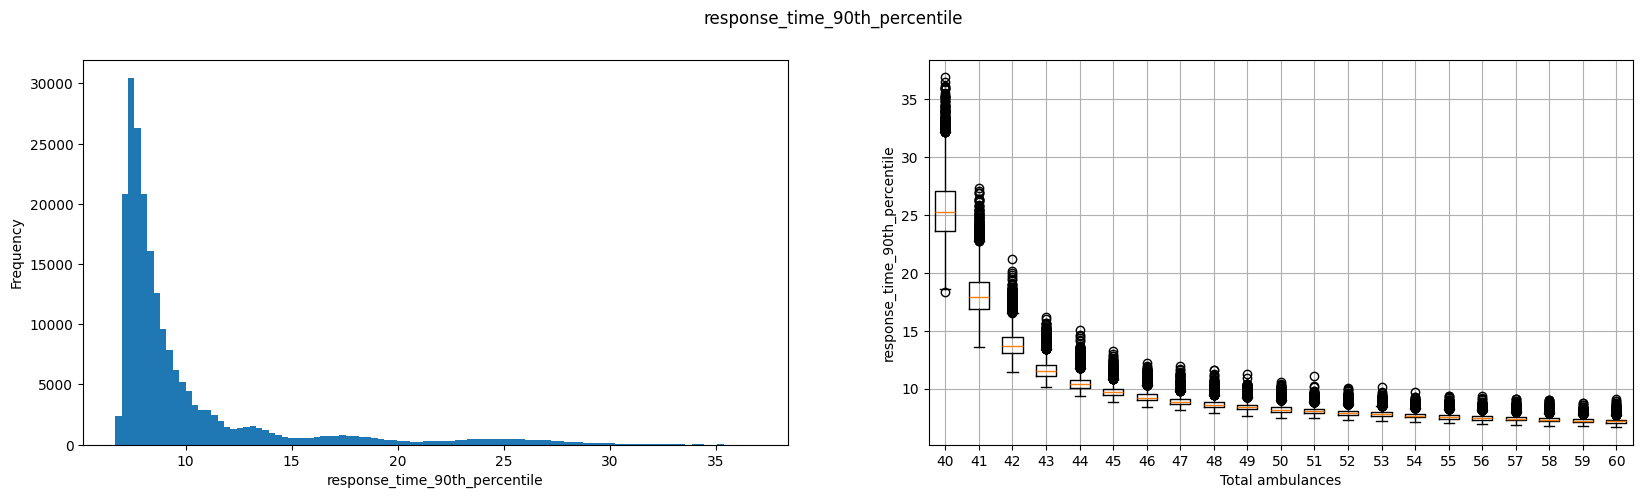

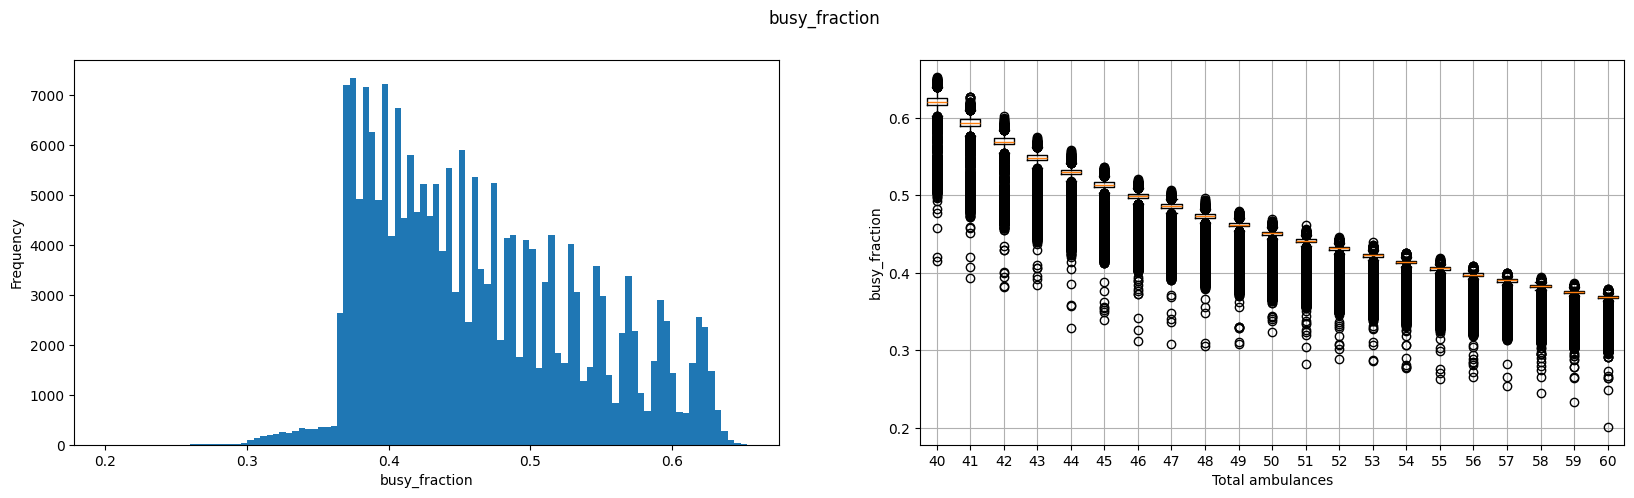

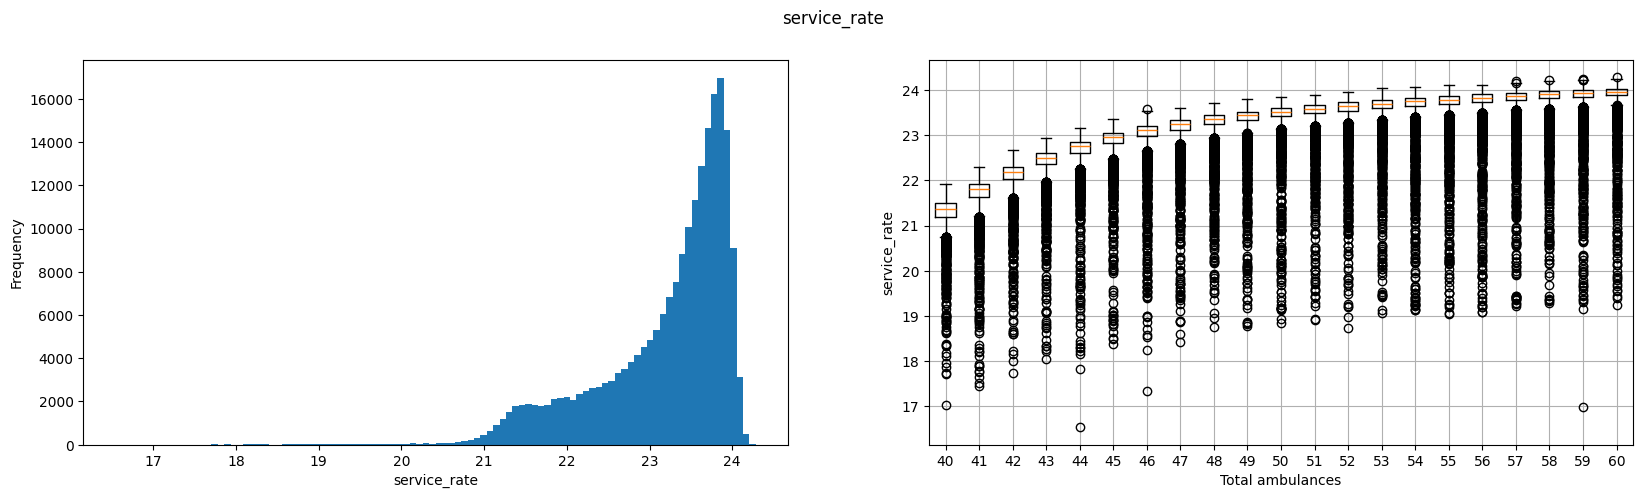

In [2]:
N_AMBULANCES = 50  # 43, 50, 57

region_id = 1
with open('ems_data.pkl', 'rb') as f:
    ems_data = pickle.load(f)
ems_data.region_id = region_id
demand_nodes = EMSData.read_patient_locations(region_id, test_id=0)
n_stations = len(ems_data.stations)
n_demand_nodes = len(demand_nodes)
print(f"# stations: {n_stations}")
print(f"# demand nodes: {n_demand_nodes}")
distance = Simulation.driving_distance(demand_nodes, ems_data.stations)
sim = Simulation(ems_data, n_days=100, n_replications=5)

dataset = pd.read_csv(f'dataset{region_id}.csv')
X = dataset.drop(columns=METRICS).to_numpy()
Y = dataset[METRICS].to_numpy()

for metric in METRICS:
    y = Y[:, METRICS.index(metric)]
    plot_metric(X, y, metric)

In [3]:
# Estimate busy_fraction and service_rate
BUSY_FRACTION = {}
SERVICE_RATE = {}
for n_ambulances in [43, 50, 57]:
    # Busy fraction used by MEXCLP so estimate using best w.r.t. coverage_9min
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'coverage_9min')
    BUSY_FRACTION[n_ambulances] = y['busy_fraction']
    # Service rate used by p-median + queueing model so estimate using best w.r.t. response_time_mean
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'response_time_mean')
    SERVICE_RATE[n_ambulances] = y['service_rate']
print(f"BUSY_FRACTION = {BUSY_FRACTION}\nSERVICE_RATE = {SERVICE_RATE}")

BUSY_FRACTION = {43: 0.5378511773938689, 50: 0.4369429489820591, 57: 0.3874100103626275}
SERVICE_RATE = {43: 22.94662688807342, 50: 23.824098402950032, 57: 24.11136495764099}


# Coverage

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Coverage (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Coverage (transformed)'>],
       dtype=object))

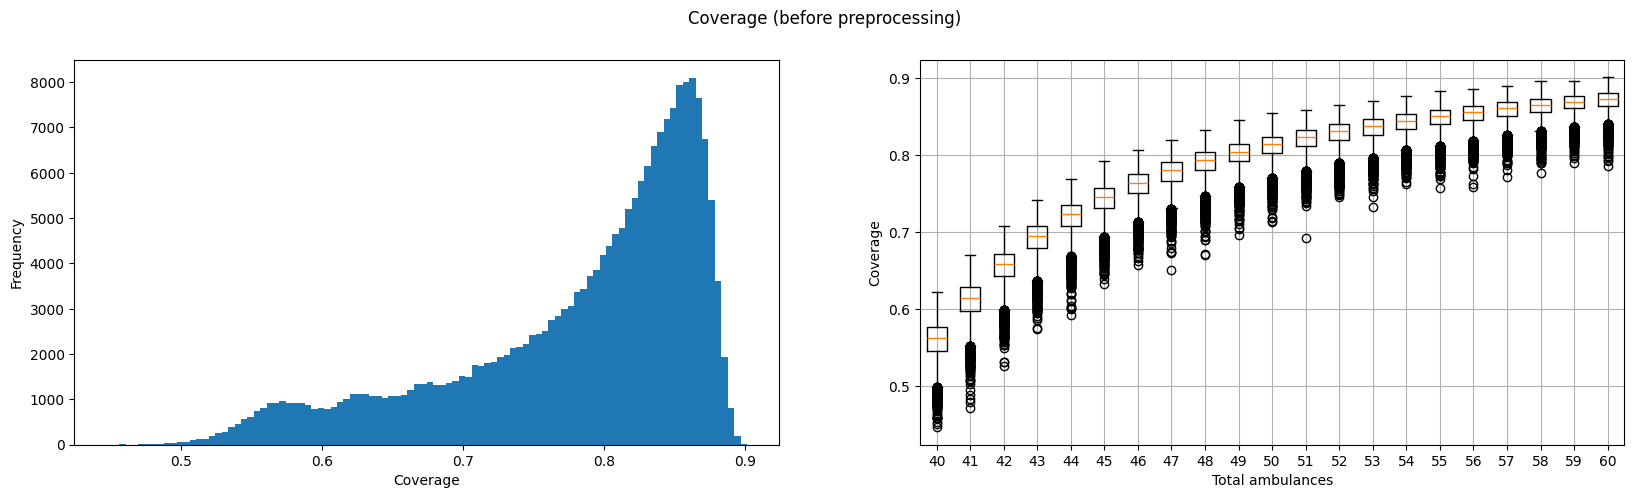

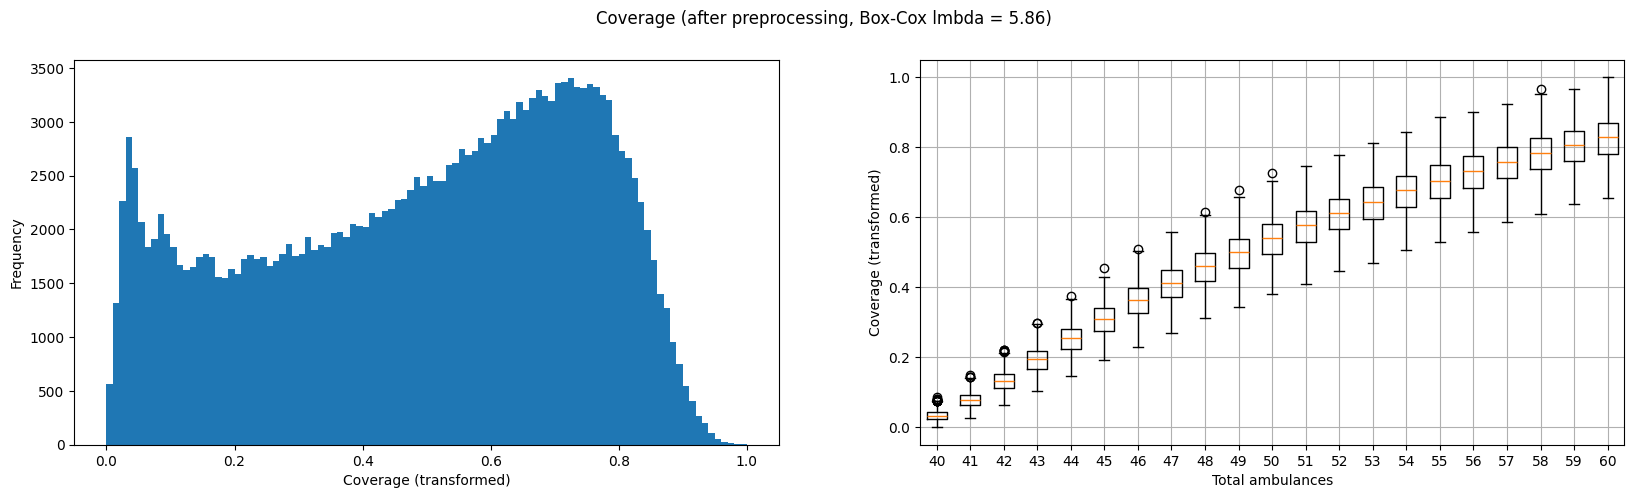

In [4]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.coverage_9min.to_numpy()
plot_metric(X, y, "Coverage (before preprocessing)", "Coverage")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Coverage (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Coverage (transformed)")

In [5]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='toronto_coverage'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 52%|█████▏    | 52/100 [02:59<02:46,  3.46s/epoch, best_val_loss=7.47e-5, train_loss=8.25e-5, val_loss=7.93e-5]  


Early stopping


100%|██████████| 100/100 [05:19<00:00,  3.20s/epoch, best_val_loss=5.11e-5, train_loss=5.01e-5, val_loss=5.11e-5]


In [6]:
weights, biases = MLP.load_npz('toronto_coverage.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-17
Set parameter TimeLimit to value 600
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4055 rows, 3094 columns and 55147 nonzeros
Model fingerprint: 0xee9c461a
Variable types: 2048 continuous, 1046 integer (1000 binary)
Coefficient statistics:
  Matrix range     [8e-07, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [9e-04, 5e+01]
Presolve removed 85 rows and 75 columns
Presolve time: 0.05s
Presolved: 3970 rows, 3019 columns, 53814 nonzeros
Variable types: 1982 continuous, 1037 integer (991 binary)

Root relaxation: objective 6.599081e+00, 1617 iterations, 0.14 seconds (0.29 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl U

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.857666,0.990109,0.093577,4.663679,4.251295,7.459704,0.446599,23.844389
1,0.863023,0.992513,0.094272,4.611410,4.233539,7.378843,0.441395,23.953064
2,0.854973,0.990369,0.093478,4.665411,4.252899,7.499959,0.444298,23.868035
3,0.860900,0.990271,0.094105,4.627474,4.222414,7.429793,0.443741,23.846702
4,0.858740,0.990883,0.093746,4.639883,4.242946,7.421253,0.446416,23.874178


In [7]:
results.mean()

coverage_9min                     0.859060
coverage_15min                    0.990829
survival_rate                     0.093836
response_time_mean                4.641571
response_time_median              4.240618
response_time_90th_percentile     7.437910
busy_fraction                     0.444490
service_rate                     23.877274
dtype: float64

# Survival

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Survival rate (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Survival rate (transformed)'>],
       dtype=object))

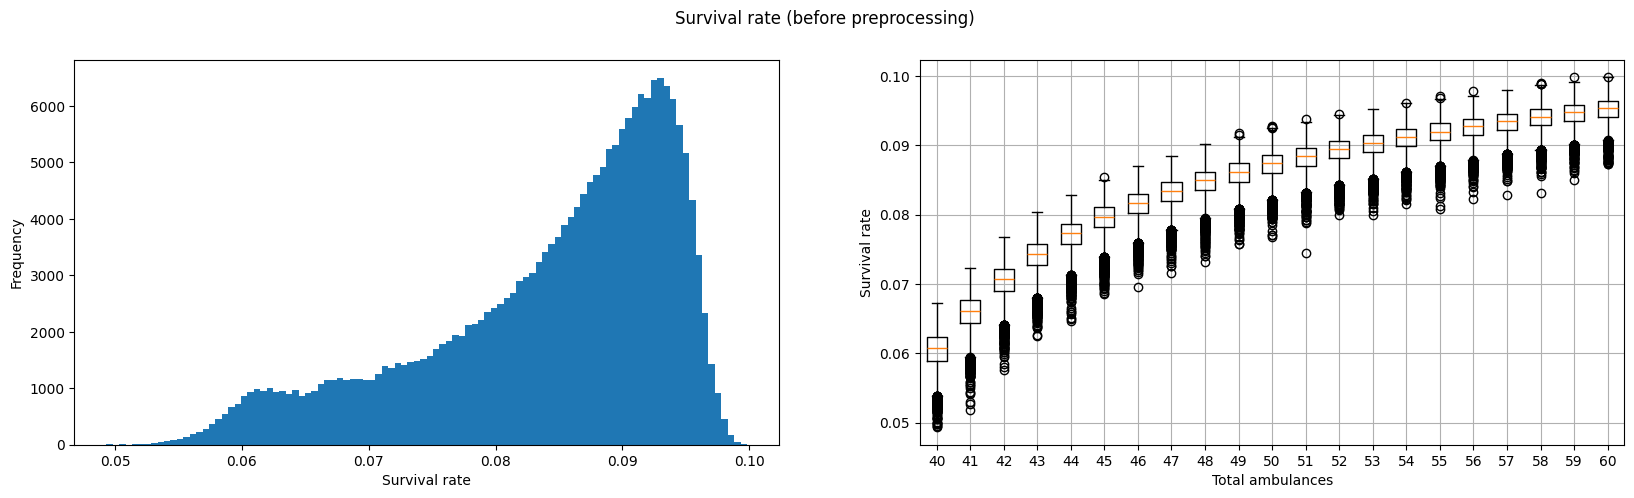

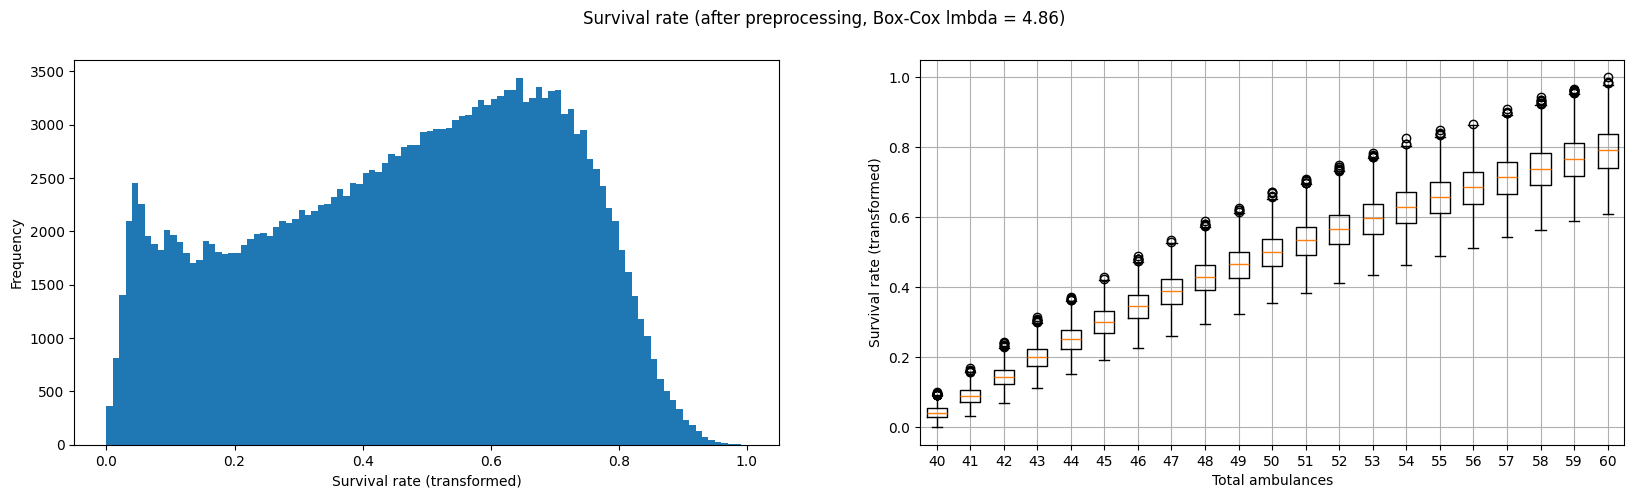

In [8]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.survival_rate.to_numpy()
plot_metric(X, y, "Survival rate (before preprocessing)", "Survival rate")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Survival rate (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Survival rate (transformed)")

In [9]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='toronto_survival'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 64%|██████▍   | 64/100 [04:09<02:20,  3.90s/epoch, best_val_loss=0.000398, train_loss=0.0013, val_loss=0.000492] 


Early stopping


 91%|█████████ | 91/100 [05:46<00:34,  3.81s/epoch, best_val_loss=7.44e-5, train_loss=7.84e-5, val_loss=0.000101]  


Early stopping


100%|██████████| 100/100 [05:46<00:00,  3.46s/epoch, best_val_loss=4.65e-5, train_loss=4.54e-5, val_loss=4.65e-5]


In [10]:
weights, biases = MLP.load_npz('toronto_survival.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 600
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4055 rows, 3094 columns and 55147 nonzeros
Model fingerprint: 0x96ba0916
Variable types: 2048 continuous, 1046 integer (1000 binary)
Coefficient statistics:
  Matrix range     [4e-07, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e-03, 5e+01]
Presolve removed 81 rows and 72 columns
Presolve time: 0.05s
Presolved: 3974 rows, 3022 columns, 53858 nonzeros
Variable types: 1984 continuous, 1038 integer (992 binary)

Root relaxation: objective 6.999638e+00, 1850 iterations, 0.19 seconds (0.38 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.99

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.858199,0.990928,0.094767,4.609219,4.198964,7.449543,0.443292,23.908466
1,0.857996,0.990695,0.094865,4.608666,4.179602,7.487559,0.440107,23.960157
2,0.854320,0.989743,0.094480,4.638753,4.207132,7.532992,0.440790,24.005139
3,0.853598,0.989264,0.094146,4.662307,4.227633,7.565835,0.445039,23.926938
4,0.852384,0.990321,0.093945,4.656829,4.226690,7.576964,0.444623,23.875958


In [11]:
results.mean()

coverage_9min                     0.855299
coverage_15min                    0.990190
survival_rate                     0.094441
response_time_mean                4.635155
response_time_median              4.208004
response_time_90th_percentile     7.522579
busy_fraction                     0.442770
service_rate                     23.935332
dtype: float64

# p-Median

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Mean response time (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Mean response time (transformed)'>],
       dtype=object))

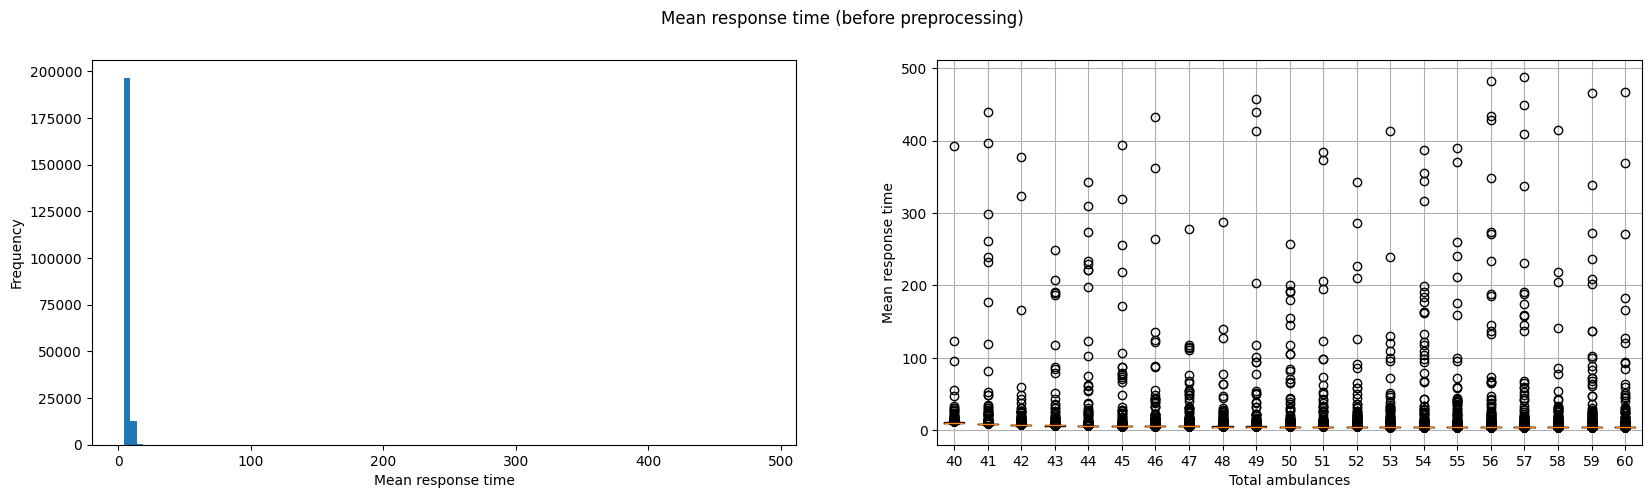

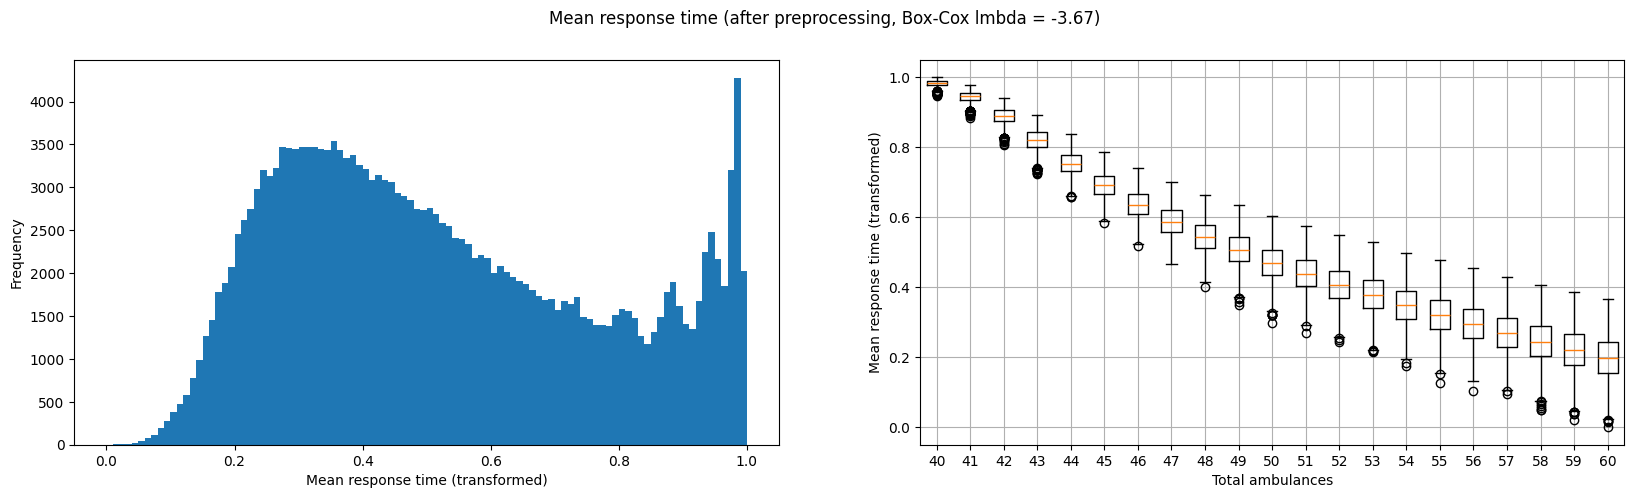

In [12]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.response_time_mean.to_numpy()
plot_metric(X, y, "Mean response time (before preprocessing)", "Mean response time")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Mean response time (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Mean response time (transformed)")

In [13]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='toronto_pmedian'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 34%|███▍      | 34/100 [02:04<04:02,  3.67s/epoch, best_val_loss=0.000488, train_loss=0.00172, val_loss=0.000724]


Early stopping


 73%|███████▎  | 73/100 [04:14<01:34,  3.49s/epoch, best_val_loss=0.000114, train_loss=0.000119, val_loss=0.000114]

Early stopping


In [14]:
weights, biases = MLP.load_npz('toronto_pmedian.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 600
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4051 rows, 3094 columns and 55143 nonzeros
Model fingerprint: 0xca9ef8d1
Variable types: 2048 continuous, 1046 integer (1000 binary)
Coefficient statistics:
  Matrix range     [6e-07, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e-05, 5e+01]
Found heuristic solution: objective 2.7974137
Presolve removed 57 rows and 54 columns
Presolve time: 0.04s
Presolved: 3994 rows, 3040 columns, 53984 nonzeros
Variable types: 1996 continuous, 1044 integer (998 binary)

Root relaxation: objective -8.821999e+00, 1590 iterations, 0.14 seconds (0.27 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.856635,0.989793,0.094421,4.638631,4.223786,7.491594,0.444456,23.929098
1,0.860139,0.990550,0.094487,4.622272,4.216178,7.414905,0.439681,23.943913
2,0.858580,0.990355,0.094454,4.626791,4.216539,7.453337,0.445499,23.809962
3,0.854238,0.990028,0.093682,4.671299,4.239890,7.559334,0.447070,23.895853
4,0.858646,0.990058,0.094508,4.633381,4.213928,7.472073,0.445350,23.970966


In [15]:
results.mean()

coverage_9min                     0.857647
coverage_15min                    0.990157
survival_rate                     0.094310
response_time_mean                4.638475
response_time_median              4.222064
response_time_90th_percentile     7.478249
busy_fraction                     0.444411
service_rate                     23.909959
dtype: float64